# Question 2: Binary Decision-Making and Hypothesis Testing

### Research Question: for each state (NY and CA) by county, is there a significant association between temporal mobility and COVID-19 cases in 2020? (multiple hypothesis testing).

## EDA

In [77]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pdpipe as pdp

import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
import time
from datetime import datetime

In [2]:
# Reading mobility data and dropping irrelevent columns

mobility = pd.read_csv('2020_US_Region_Mobility_Report.csv')
mobility = mobility.rename(columns = {'sub_region_2': 'County'})
mobility['date'] = pd.to_datetime(mobility['date'])
mobility = mobility.drop(['iso_3166_2_code', 'country_region_code', 'country_region', 'metro_area', 'place_id',
                                'census_fips_code'], axis = 1)
ca_mobility = mobility[mobility.sub_region_1 == "California"].dropna()
ca_mobility['County'] = ca_mobility['County'].str.replace(' County', '')
ny_mobility = mobility[mobility.sub_region_1 == "New York"].dropna()
ny_mobility['County'] = ny_mobility['County'].str.replace(' County', '')

In [3]:
ny_mobility.head()

,sub_region_1,County,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
466272,New York,Albany,2020-02-15,8.0,-4.0,45.0,4.0,0.0,0.0
466273,New York,Albany,2020-02-16,7.0,-6.0,8.0,-1.0,2.0,-1.0
466274,New York,Albany,2020-02-17,11.0,2.0,-23.0,-7.0,-41.0,9.0
466275,New York,Albany,2020-02-18,-7.0,-7.0,-33.0,0.0,-9.0,3.0
466276,New York,Albany,2020-02-19,4.0,-3.0,-21.0,2.0,-8.0,2.0


In [4]:
ca_mobility.head()

,sub_region_1,County,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
48386,California,Alameda,2020-02-15,1.0,0.0,22.0,1.0,0.0,-1.0
48387,California,Alameda,2020-02-16,7.0,0.0,24.0,5.0,1.0,-2.0
48388,California,Alameda,2020-02-17,13.0,1.0,55.0,-31.0,-53.0,11.0
48389,California,Alameda,2020-02-18,-2.0,3.0,21.0,3.0,0.0,0.0
48390,California,Alameda,2020-02-19,-1.0,0.0,14.0,1.0,0.0,0.0


In [5]:
# Reading data for confirmed cases, deaths and recoveries for COVID-19 in CA

ca_cases = pd.read_csv("ca_cases.csv")
ca_cases = ca_cases[['date', 'area', 'positive_tests', 'cumulative_positive_tests', 'total_tests', 
                    'cumulative_total_tests']]
ca_cases['date'] = pd.to_datetime(ca_cases['date'])
ca_cases = ca_cases.rename(columns = {'area': 'County'}).dropna()

ca_cases = ca_cases[ca_cases['date'] < datetime(year=2021, month=1, day=1)]
ca_cases.head()

,date,County,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,2020-02-01,Alameda,0.0,0,4.0,4
1,2020-02-01,Stanislaus,0.0,0,1.0,1
2,2020-02-01,Alpine,0.0,0,0.0,0
3,2020-02-01,Sonoma,0.0,0,0.0,0
4,2020-02-01,Amador,0.0,0,0.0,0


In [6]:
# Reading data for confirmed cases, deaths and recoveries for COVID-19 in NY

ny_cases = pd.read_csv("New_York_State_Statewide_COVID-19_Testing.csv")
ny_cases = ny_cases.rename(columns = {'Test Date': 'date', 'New Positives': 'positive_tests',
                                     'Cumulative Number of Positives': 'cumulative_positive_tests',
                                     'Total Number of Tests Performed': 'total_tests',
                                     'Cumulative Number of Tests Performed': 'cumulative_total_tests'}).dropna()
ny_cases['date'] = pd.to_datetime(ny_cases['date'])
ny_cases = ny_cases[ny_cases['date'] < datetime(year=2021, month=1, day=1)]
ny_cases.head()

,date,County,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,2020-03-01,Albany,0,0,0,0
1,2020-03-02,Albany,0,0,0,0
2,2020-03-03,Albany,0,0,0,0
3,2020-03-04,Albany,0,0,0,0
4,2020-03-05,Albany,0,0,3,3


In [17]:
ca_data = pd.merge(ca_mobility, ca_cases,  how = 'inner', left_on = ['date','County'], right_on = ['date','County'])
ca_data = ca_data.rename(columns = {'sub_region_1': 'state'})
ca_data = ca_data.sort_values('date')
ca_data['prop_positive'] = ca_data['positive_tests']/ca_data['total_tests']
ca_data['retail_and_recreation_prop_change_from_baseline'] = ca_data['retail_and_recreation_percent_change_from_baseline']/100
ca_data['grocery_and_pharmacy_prop_change_from_baseline'] = ca_data['grocery_and_pharmacy_percent_change_from_baseline']/100
ca_data['parks_prop_change_from_baseline'] = ca_data['parks_percent_change_from_baseline']/100
ca_data['transit_stations_prop_change_from_baseline'] = ca_data['transit_stations_percent_change_from_baseline']/100
ca_data['workplaces_prop_change_from_baseline'] = ca_data['workplaces_percent_change_from_baseline']/100
ca_data['residential_prop_change_from_baseline'] = ca_data['residential_percent_change_from_baseline']/100
ca_data = ca_data.dropna()
ca_data = ca_data[['state', 'County', 'date', 'prop_positive', 'retail_and_recreation_prop_change_from_baseline',
                  'grocery_and_pharmacy_prop_change_from_baseline', 'parks_prop_change_from_baseline',
                  'transit_stations_prop_change_from_baseline', 'workplaces_prop_change_from_baseline',
                  'residential_prop_change_from_baseline']]
ca_data = ca_data[ca_data['prop_positive'] != 1]
ca_data.head()

,state,County,date,prop_positive,retail_and_recreation_prop_change_from_baseline,grocery_and_pharmacy_prop_change_from_baseline,parks_prop_change_from_baseline,transit_stations_prop_change_from_baseline,workplaces_prop_change_from_baseline,residential_prop_change_from_baseline
10545,California,Ventura,2020-02-15,0.0,0.01,-0.02,0.07,-0.01,-0.01,0.00
10249,California,Tulare,2020-02-15,0.0,0.01,0.01,0.22,0.15,-0.03,0.00
2190,California,Kings,2020-02-15,0.0,0.07,-0.01,0.14,0.16,-0.03,-0.01
2663,California,Los Angeles,2020-02-15,0.0,0.01,0.00,0.13,-0.01,-0.01,0.00
7351,California,San Luis Obispo,2020-02-15,0.0,0.16,0.09,0.43,0.09,0.00,-0.01


Text(0.5, 1.0, 'Prop Change in Residential Mobility Cubed Against Prop Positive Tests (CA)')

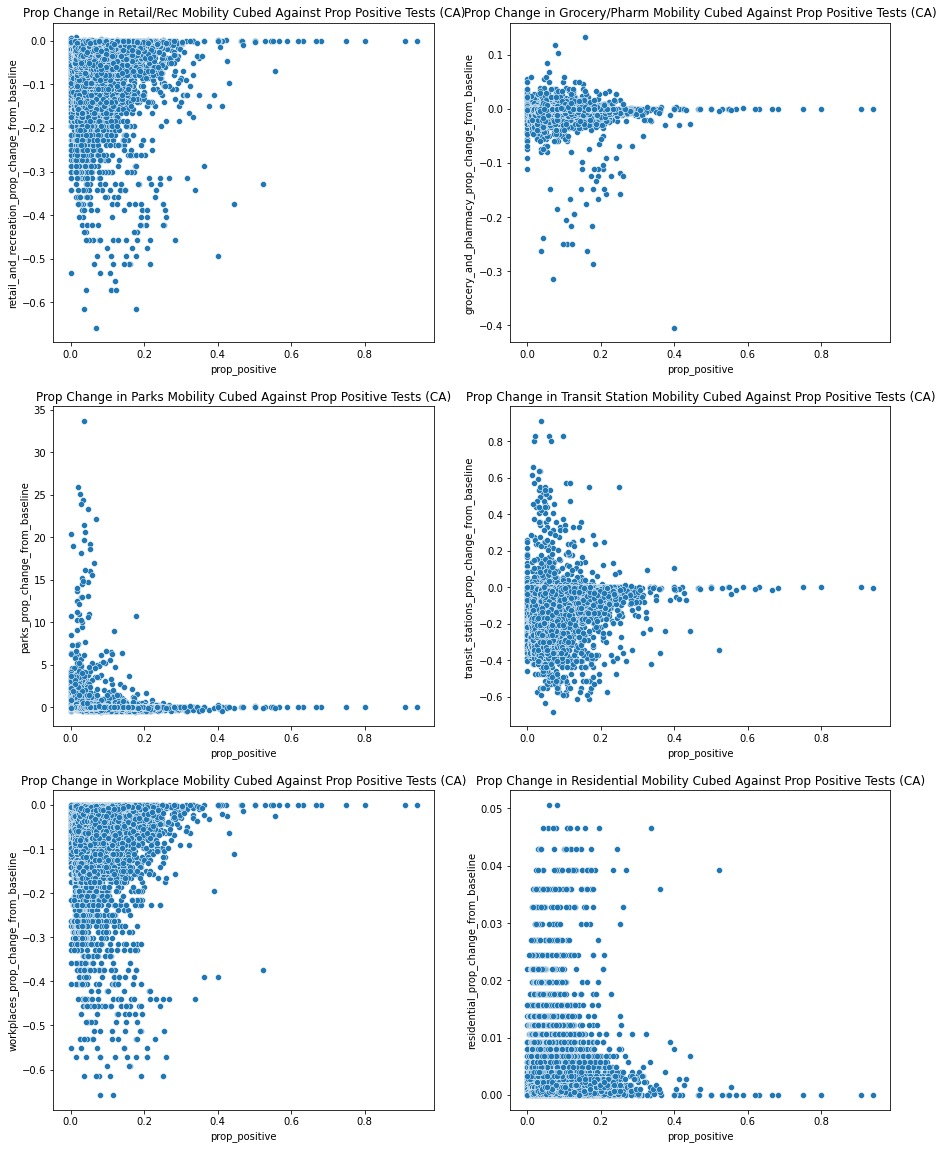

In [88]:
fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ca_data['prop_positive'], ca_data['retail_and_recreation_prop_change_from_baseline']**3, 
                ax = ax[0][0]).set_title(
'Prop Change in Retail/Rec Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['grocery_and_pharmacy_prop_change_from_baseline']**3,
               ax = ax[0][1]).set_title(
'Prop Change in Grocery/Pharm Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['parks_prop_change_from_baseline']**3, 
                ax = ax[1][0]).set_title(
'Prop Change in Parks Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['transit_stations_prop_change_from_baseline']**3, 
                ax = ax[1][1]).set_title(
'Prop Change in Transit Station Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['workplaces_prop_change_from_baseline']**3, 
                ax = ax[2][0]).set_title(
'Prop Change in Workplace Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['residential_prop_change_from_baseline']**3, 
                ax = ax[2][1]).set_title(
'Prop Change in Residential Mobility Cubed Against Prop Positive Tests (CA)')



In [45]:
ca_data['test_stat_retail_and_recreation'] = (ca_data['retail_and_recreation_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_grocery_and_pharmacy'] = (ca_data['grocery_and_pharmacy_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_parks'] = (ca_data['parks_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_transit_stations'] = (ca_data['transit_stations_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_workplaces'] = (ca_data['workplaces_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_residential'] = (ca_data['residential_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data.head()

,state,County,date,prop_positive,retail_and_recreation_prop_change_from_baseline,grocery_and_pharmacy_prop_change_from_baseline,parks_prop_change_from_baseline,transit_stations_prop_change_from_baseline,workplaces_prop_change_from_baseline,residential_prop_change_from_baseline,test_stat,test_stat_retail_and_recreation,test_stat_grocery_and_pharmacy,test_stat_parks,test_stat_transit_stations,test_stat_workplaces,test_stat_residential
10545,California,Ventura,2020-02-15,0.0,0.01,-0.02,0.07,-0.01,-0.01,0.00,0.01,0.01,-0.02,0.07,-0.01,-0.01,0.00
10249,California,Tulare,2020-02-15,0.0,0.01,0.01,0.22,0.15,-0.03,0.00,0.01,0.01,0.01,0.22,0.15,-0.03,0.00
2190,California,Kings,2020-02-15,0.0,0.07,-0.01,0.14,0.16,-0.03,-0.01,0.07,0.07,-0.01,0.14,0.16,-0.03,-0.01
2663,California,Los Angeles,2020-02-15,0.0,0.01,0.00,0.13,-0.01,-0.01,0.00,0.01,0.01,0.00,0.13,-0.01,-0.01,0.00
7351,California,San Luis Obispo,2020-02-15,0.0,0.16,0.09,0.43,0.09,0.00,-0.01,0.16,0.16,0.09,0.43,0.09,0.00,-0.01


Text(0.5, 1.0, 'Impact of Positive Cases on Residential Mobility (CA)')

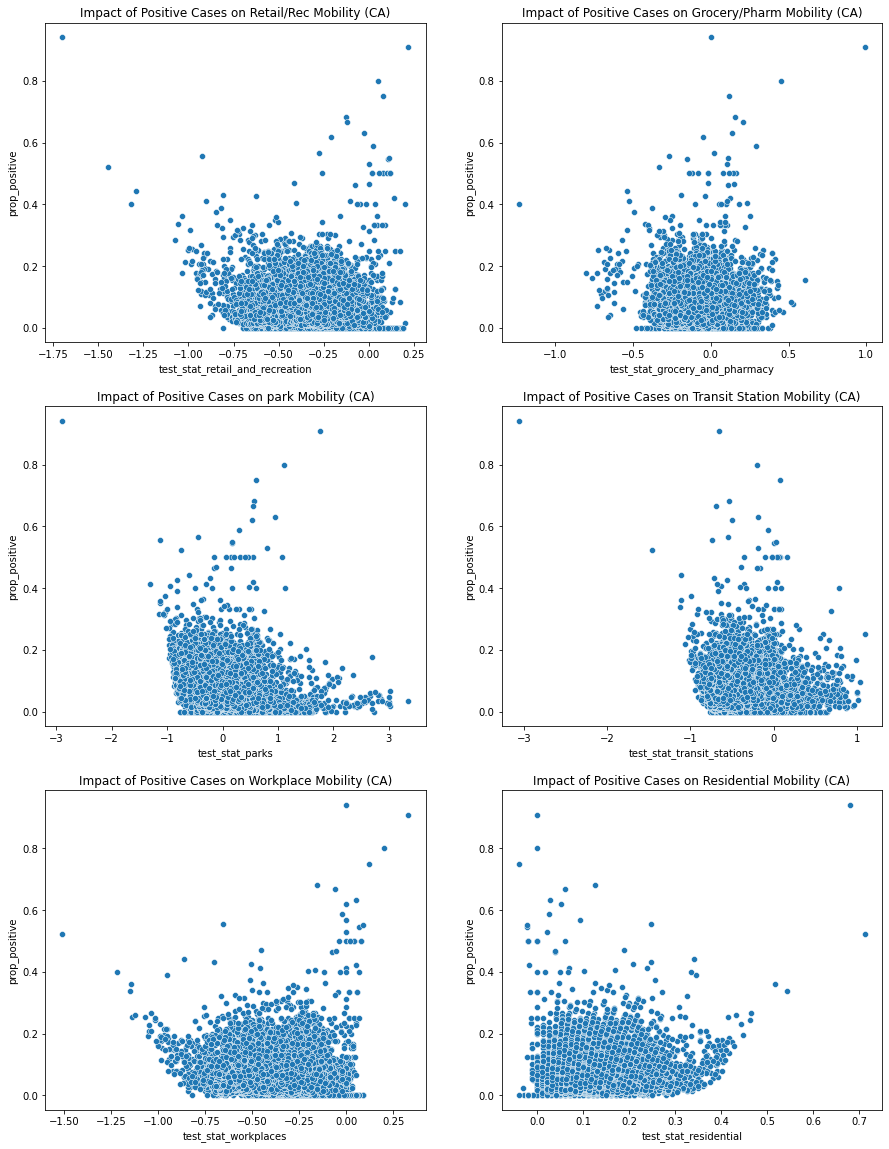

In [92]:
fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ca_data['test_stat_retail_and_recreation'], ca_data['prop_positive'],
                ax = ax[0][0]).set_title(
'Impact of Positive Cases on Retail/Rec Mobility (CA)')

sns.scatterplot(ca_data['test_stat_grocery_and_pharmacy'], ca_data['prop_positive'],
               ax = ax[0][1]).set_title(
'Impact of Positive Cases on Grocery/Pharm Mobility (CA)')

sns.scatterplot(ca_data['test_stat_parks'], ca_data['prop_positive'],
                ax = ax[1][0]).set_title(
'Impact of Positive Cases on park Mobility (CA)')

sns.scatterplot(ca_data['test_stat_transit_stations'], ca_data['prop_positive'],
                ax = ax[1][1]).set_title(
'Impact of Positive Cases on Transit Station Mobility (CA)')

sns.scatterplot(ca_data['test_stat_workplaces'], ca_data['prop_positive'],
                ax = ax[2][0]).set_title(
'Impact of Positive Cases on Workplace Mobility (CA)')

sns.scatterplot(ca_data['test_stat_residential'], ca_data['prop_positive'],
                ax = ax[2][1]).set_title(
'Impact of Positive Cases on Residential Mobility (CA)')

In [33]:
ny_data = pd.merge(ny_mobility, ny_cases,  how = 'inner', left_on = ['date','County'], right_on = ['date','County'])
ny_data = ny_data.rename(columns = {'sub_region_1': 'state'})
ny_data = ny_data.sort_values('date')
ny_data['prop_positive'] = ny_data['positive_tests']/ny_data['total_tests']
ny_data['retail_and_recreation_prop_change_from_baseline'] = ny_data['retail_and_recreation_percent_change_from_baseline']/100
ny_data['grocery_and_pharmacy_prop_change_from_baseline'] = ny_data['grocery_and_pharmacy_percent_change_from_baseline']/100
ny_data['parks_prop_change_from_baseline'] = ny_data['parks_percent_change_from_baseline']/100
ny_data['transit_stations_prop_change_from_baseline'] = ny_data['transit_stations_percent_change_from_baseline']/100
ny_data['workplaces_prop_change_from_baseline'] = ny_data['workplaces_percent_change_from_baseline']/100
ny_data['residential_prop_change_from_baseline'] = ny_data['residential_percent_change_from_baseline']/100
ny_data = ny_data.dropna()
ny_data = ny_data[['state', 'County', 'date', 'prop_positive', 'retail_and_recreation_prop_change_from_baseline',
                  'grocery_and_pharmacy_prop_change_from_baseline', 'parks_prop_change_from_baseline',
                  'transit_stations_prop_change_from_baseline', 'workplaces_prop_change_from_baseline',
                  'residential_prop_change_from_baseline']]
ny_data = ny_data[ny_data['prop_positive'] != 1]
ny_data.head()

,state,County,date,prop_positive,retail_and_recreation_prop_change_from_baseline,grocery_and_pharmacy_prop_change_from_baseline,parks_prop_change_from_baseline,transit_stations_prop_change_from_baseline,workplaces_prop_change_from_baseline,residential_prop_change_from_baseline
5378,New York,Westchester,2020-03-03,0.0,0.05,0.03,0.08,-0.01,0.03,0.0
249,New York,Bronx,2020-03-03,0.0,0.08,0.07,0.06,0.04,0.04,0.0
3431,New York,Queens,2020-03-03,0.0,0.02,0.04,0.09,-0.03,0.04,0.0
1262,New York,Kings,2020-03-03,0.0,0.04,0.06,0.06,0.02,0.04,0.0
2088,New York,New York,2020-03-03,0.0,0.00,0.06,0.05,-0.01,0.03,0.0


Text(0.5, 1.0, 'Prop Change in Residential Mobility Cubed Against Prop Positive Tests (NY)')

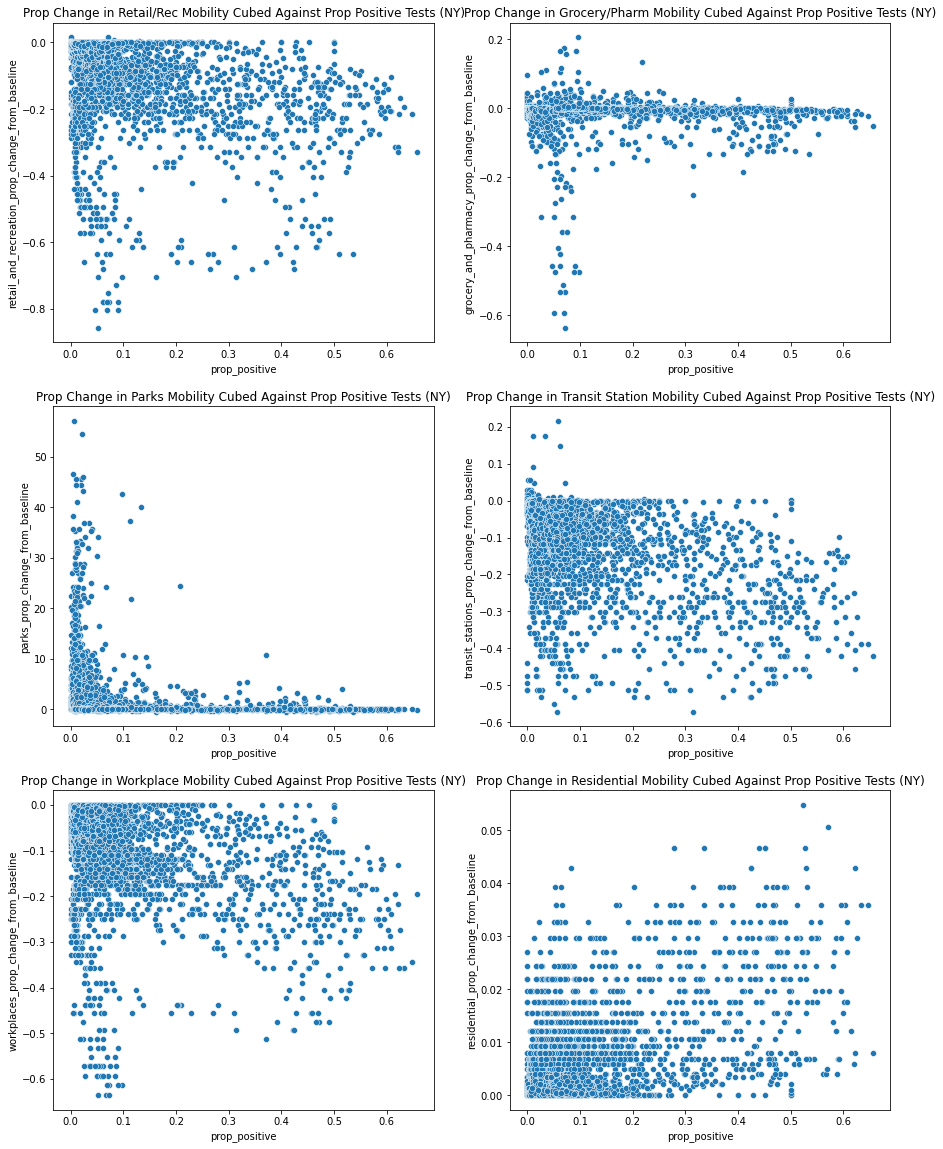

In [89]:
fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ny_data['prop_positive'], ny_data['retail_and_recreation_prop_change_from_baseline']**3, 
                ax = ax[0][0]).set_title(
'Prop Change in Retail/Rec Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['grocery_and_pharmacy_prop_change_from_baseline']**3,
               ax = ax[0][1]).set_title(
'Prop Change in Grocery/Pharm Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['parks_prop_change_from_baseline']**3, 
                ax = ax[1][0]).set_title(
'Prop Change in Parks Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['transit_stations_prop_change_from_baseline']**3, 
                ax = ax[1][1]).set_title(
'Prop Change in Transit Station Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['workplaces_prop_change_from_baseline']**3, 
                ax = ax[2][0]).set_title(
'Prop Change in Workplace Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['residential_prop_change_from_baseline']**3, 
                ax = ax[2][1]).set_title(
'Prop Change in Residential Mobility Cubed Against Prop Positive Tests (NY)')




In [53]:
ny_data['test_stat_retail_and_recreation'] = (ny_data['retail_and_recreation_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_grocery_and_pharmacy'] = (ny_data['grocery_and_pharmacy_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_parks'] = (ny_data['parks_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_transit_stations'] = (ny_data['transit_stations_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_workplaces'] = (ny_data['workplaces_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_residential'] = (ny_data['residential_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data.head()

,state,County,date,prop_positive,retail_and_recreation_prop_change_from_baseline,grocery_and_pharmacy_prop_change_from_baseline,parks_prop_change_from_baseline,transit_stations_prop_change_from_baseline,workplaces_prop_change_from_baseline,residential_prop_change_from_baseline,test_stat_retail_and_recreation,test_stat_grocery_and_pharmacy,test_stat_parks,test_stat_transit_stations,test_stat_workplaces,test_stat_residential
5378,New York,Westchester,2020-03-03,0.0,0.05,0.03,0.08,-0.01,0.03,0.0,0.05,0.03,0.08,-0.01,0.03,0.0
249,New York,Bronx,2020-03-03,0.0,0.08,0.07,0.06,0.04,0.04,0.0,0.08,0.07,0.06,0.04,0.04,0.0
3431,New York,Queens,2020-03-03,0.0,0.02,0.04,0.09,-0.03,0.04,0.0,0.02,0.04,0.09,-0.03,0.04,0.0
1262,New York,Kings,2020-03-03,0.0,0.04,0.06,0.06,0.02,0.04,0.0,0.04,0.06,0.06,0.02,0.04,0.0
2088,New York,New York,2020-03-03,0.0,0.00,0.06,0.05,-0.01,0.03,0.0,0.00,0.06,0.05,-0.01,0.03,0.0


Text(0.5, 1.0, 'Impact of Positive Cases on Residential Mobility (CA)')

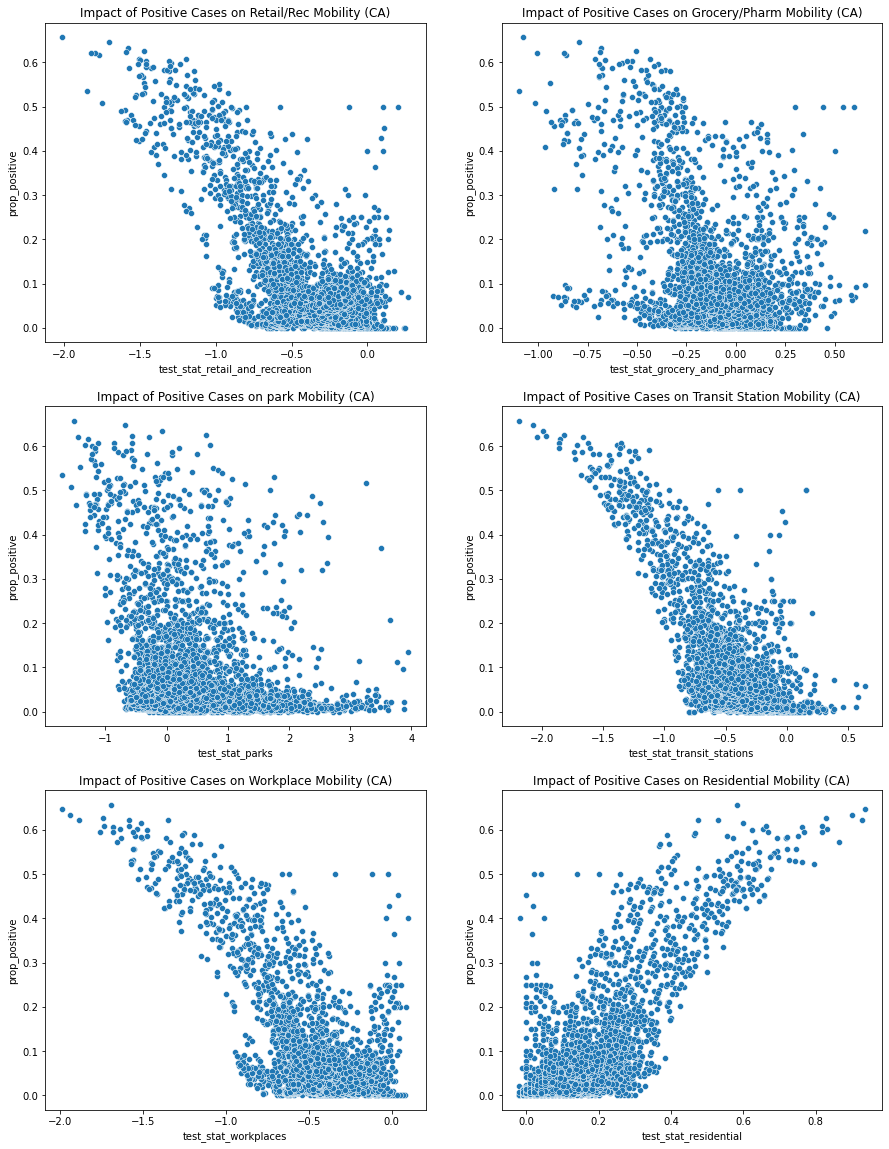

In [93]:
fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ny_data['test_stat_retail_and_recreation'], ny_data['prop_positive'],
                ax = ax[0][0]).set_title(
'Impact of Positive Cases on Retail/Rec Mobility (CA)')

sns.scatterplot(ny_data['test_stat_grocery_and_pharmacy'], ny_data['prop_positive'],
               ax = ax[0][1]).set_title(
'Impact of Positive Cases on Grocery/Pharm Mobility (CA)')

sns.scatterplot(ny_data['test_stat_parks'], ny_data['prop_positive'],
                ax = ax[1][0]).set_title(
'Impact of Positive Cases on park Mobility (CA)')

sns.scatterplot(ny_data['test_stat_transit_stations'], ny_data['prop_positive'],
                ax = ax[1][1]).set_title(
'Impact of Positive Cases on Transit Station Mobility (CA)')

sns.scatterplot(ny_data['test_stat_workplaces'], ny_data['prop_positive'],
                ax = ax[2][0]).set_title(
'Impact of Positive Cases on Workplace Mobility (CA)')

sns.scatterplot(ny_data['test_stat_residential'], ny_data['prop_positive'],
                ax = ax[2][1]).set_title(
'Impact of Positive Cases on Residential Mobility (CA)')